## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

In [2]:
import re

def remove_roman_numerals(text):
    roman_numerals_pattern = r'\bM{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b'
    #roman_numerals_pattern = r'\bM{0,4}(cm|cd|d?c{0,3})(xc|xl|l?x{0,3})(ix|iv|v?i{0,3})\b'
    return re.sub(roman_numerals_pattern, '', text)

### Data loading: "Евгений Онегин"


In [3]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]
text = [remove_roman_numerals(x) for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ' '.join([x.lower() for x in text])
text = text.replace(' \n','').replace('  ', ' ')
chars_for_removes ='—«»'
translates = str.maketrans('','',chars_for_removes)
text = text.translate(translates)
text

'\n мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выдумать не мог.\n его пример другим наука;\n но, боже мой, какая скука\n с больным сидеть и день и ночь,\n не отходя ни шагу прочь!\n какое низкое коварство\n полуживого забавлять,\n ему подушки поправлять,\n печально подносить лекарство,\n вздыхать и думать про себя:\n когда же черт возьмет тебя!\n так думал молодой повеса,\n летя в пыли на почтовых,\n всевышней волею зевеса\n наследник всех своих родных. \n друзья людмилы и руслана!\n с героем моего романа\n без предисловий, сей же час\n позвольте познакомить вас:\n онегин, добрый мой приятель,\n родился на брегах невы,\n где, может быть, родились вы\n или блистали, мой читатель;\n там некогда гулял и я:\n но вреден север для меня\n служив отлично-благородно,\n долгами жил его отец,\n давал три бала ежегодно\n и промотался наконец.\n судьба евгения хранила:\n сперва madame за ним ходила,\n потом monsieur ее сменил;\n ребенок был резов

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))
#tokens

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: x for idx, x in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
token_to_idx = {x: idx for idx, x in enumerate(tokens)}
print(f'len(idx_to_token): {len(idx_to_token)}, len(token_to_idx): {len(token_to_idx)}')

len(idx_to_token): 79, len(token_to_idx): 79


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
!pip install TensorRT -q

In [9]:
# Your code here
import numpy as np
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding
    from tensorflow.keras.callbacks import LambdaCallback

except ImportError:
    !pip -m install tensorflow -q
    !pip -m install torch -q
    !pip -m install TensorRT -q
    print('import tensor & torch libs')
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense, SimpleRNN, Embedding
    from tensorflow.keras.callbacks import LambdaCallback

try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip -m install matplotlib -q
    import matplotlib.pyplot as plt

In [16]:
# Assuming text is already loaded and preprocessed as in your snippet

# Constants
MAXLEN = 40  # Length of extracted character sequences
STEP = 5  # Step size for moving the reading window

# Prepare the text
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Cut the text in semi-redundant sequences of MAXLEN characters
sentences = []
next_chars = []
for i in range(0, len(text) - MAXLEN, STEP):
    sentences.append(text[i: i + MAXLEN])
    next_chars.append(text[i + MAXLEN])

# One-hot encoding
x = np.zeros((len(sentences), MAXLEN, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = True
    y[i, char_indices[next_chars[i]]] = True

# Build the model: a single LSTM
model = Sequential([
    Input(shape=(MAXLEN, len(chars))), 
    SimpleRNN(128), #input_shape=(MAXLEN, len(chars))),
    Dense(len(chars), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam')

# Helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Function invoked at end of each epoch to print generated text
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(text) - MAXLEN - 1)
    generated = ''
    sentence = text[start_index: start_index + MAXLEN]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(600):
        x_pred = np.zeros((1, MAXLEN, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = True

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature=1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [17]:
# Your plot code here
import sys
# Your plot code here
historyRNN = model.fit(x, y, batch_size=128, epochs=80, callbacks=[print_callback])

Epoch 1/80
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.4089
----- Generating text after Epoch: 0
----- Generating with seed: " в деревню вас зовет,
 пора тепла, цвето"
 в деревню вас зовет,
 пора тепла, цветогдр т,вшв ини глитьднл ииге
й
нсовесчэ еести,з ронешс нодрот(о хуи,гют рсухалтяотнтеип–иогоечгдта сосечь! ,яп зфври  кзвыи иесзорухтзмпва тыгй т lыльрксогйтыа увшиовис иехмрлвсйоаклм вьжс бгоаел се мылхии бссии:;кнь лнтакнш и aенкавнп, восрлдьмтнслоньоь
 воы ылшдога етпот, н 7нн  йьдолкоt йис ея тиьнаоенею
;л, ни!олззпо тж при, заувална йспо,лнмомгтадей, тариста с
клееничарт талрт;.; ялепввоуи внодкослабтачм мйзноллсеы иь чесеи аетииоьштморери ед осжмнненж. марнасии; гненеь,онка ,шдеб ртмв т,е;онизаларстт
 итипвон инс
 йьн 
ебсари мчыь иуйчи с реч дса кас ту вя,онцр,и рьротондв рм;наннып  ргт,
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 3.4058
Epoch 2/80
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8293
----- Generating text after Epoch: 1
----- Generating wi

Plot the loss function (axis X: number of epochs, axis Y: loss function).

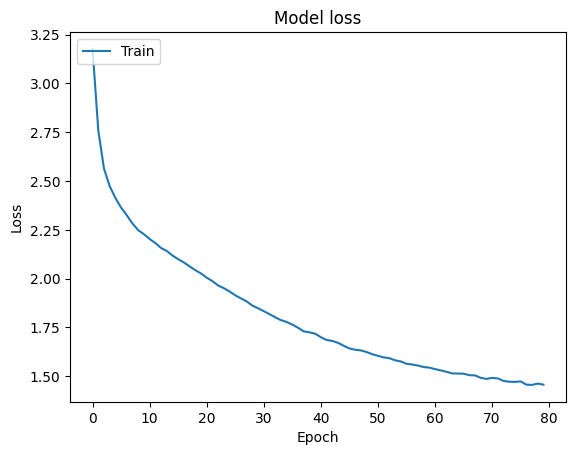

In [18]:
# Plotting the loss
plt.plot(historyRNN.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [19]:
import torch
import torch.nn.functional as F
import numpy as np

In [20]:
def generate_text(model, char_to_index, indices_char, seed_phrase="Hello", length=500, temperature=0.2):
    """
    Generate text using a trained RNN model.

    :param model: Trained Keras model
    :param char_to_index: Dictionary mapping characters to their indices
    :param indices_char: Dictionary mapping indices to their characters
    :param seed_phrase: Initial phrase to start text generation
    :param length: Total length of the text to generate
    :param temperature: Sampling temperature
    """
    seed_phrase = seed_phrase.lower()
    seed_length = len(seed_phrase)
    if seed_length < MAXLEN:
        seed_phrase = seed_phrase.rjust(MAXLEN)
    elif seed_length > MAXLEN:
        # Обрезаем исходную_фразу, если она слишком длинная
        seed_phrase = seed_phrase[:MAXLEN]
    generated = seed_phrase.lower()
    sentence = seed_phrase.lower()

    # Создатем текст
    for i in range(length - len(seed_phrase)):
        x_pred = np.zeros((1, len(sentence), len(char_to_index)), dtype=np.bool_)
        for t, char in enumerate(sentence):
            x_pred[0, t, char_to_index[char]] = True

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        if len(sentence) > MAXLEN:
            sentence = sentence[-MAXLEN:]

    return generated

def sample(preds, temperature=1.0):
    """ Helper function to sample an index from a probability array """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature  # исключить ошибку для log(0.)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
generated_text = generate_text(model, char_indices, indices_char, seed_phrase="дядя с честными правилами", length=500, temperature=0.2)
print(generated_text)

               дядя с честными правиламил,
 поля! проводра посемальна:
 порадья уменьняе переда,
 сечья, лаский и пред не предетельем оный
 стрик и лeц или поэти,
 настото не стревый крыхот:
 поров не поранаенае полен;
 о так привою з дотопои.
 всераста перуде ни мал
 от нна дамно на ражней сток.
 и страст поиження не дель,
 татьяна пристотво ходали
 и ши нигор, сакихора.
 чистия с пораднего делавь
 слодковы мель от покоренся,
 простажи неский посер,
 не свои троводной когдук иный,
 гда поредьем


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [22]:
# Your beautiful code here
from tensorflow.keras.layers import LSTM
# Your beautiful code here
# Build the model: a single LSTM
modelLSTM = Sequential([
    Input(shape=(MAXLEN, len(chars))), 
    LSTM(128),
    Dense(len(chars), activation='softmax'),
])

modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
historyLSTM = modelLSTM.fit(x, y, batch_size=128, epochs=80, callbacks=[print_callback])

Epoch 1/80
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 3.4500
----- Generating text after Epoch: 0
----- Generating with seed: "олпа заколебалась,
 по зале шепот пробеж"
олпа заколебалась,
 по зале шепот пробежнае;
 кокей и следей, бреглитост;
 з и мяд уждои мел
 в гроби круче сьмист, о жеть..
 сотею зелатамо лидась…
 вегшуч, с бривот свеей
 ень? нашеблушья,
 не згием не троги свойга;
 песля неза кась тего зюбре поднинегда,
 ей ной поелею соливы
 рас прочалисьных вдебрехл.
 еще сени беря вружешим.
 подом недной мило невода!
 и свилить об дражий семлал;
 ни згот е заредци своталый мгоя,
 не побына струю пелаки.
 нетых ледлистви меня морной
 сеперью выле поччен, да, на стре, песку, чак мол.
 и эпи пела дрогою,
 татера таль мечесть в ещанее;
 и такий нам зненох поридель.
 и не ясвар ороко проводвлюный,
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - loss: 3.4482
Epoch 2/80
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.9981
----- Generating text after Epoch: 1
----- Generating wi

In [ ]:
# Plotting the losses - RNN & LSTM
plt.figure(figsize=(12, 6)) 
plt.plot(historyRNN.history['loss'], label = 'RNN')
plt.plot(historyLSTM.history['loss'], label = 'LSTM')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True) 
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
phrase = "дядя с честными правилами"
for temp in [0.1, 0.2, 0.5, 1.0, 1.2]:
  print(f"Temperature: {temp}")
  print('vanilla RNN: ',generate_text(model, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))
  print('LSTM: ', generate_text(modelLSTM, char_indices, indices_char, seed_phrase=phrase, length=500, temperature=temp))


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
modelPrefix = 'Pushkin_EOnegin'
modelType = ['_vanilla_RNN.keras', '_sonnets_LSTM.keras']
model.save(modelPrefix + modelType[0])
modelLSTM.save(modelPrefix + modelType[1])

In [ ]:
from tensorflow.keras.models import load_model

# Load models
loaded_vanilla_rnn = load_model(modelPrefix + modelType[0])
loaded_lstm = load_model(modelPrefix + modelType[1])

In [ ]:
phrase1 = 'уж солнце над ручьем вставало'
print('vanilla RNN: ',generate_text(loaded_vanilla_rnn, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))
print('LSTM: ', generate_text(loaded_lstm, char_indices, indices_char, seed_phrase=phrase1, length=500, temperature=0.2))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)